In [2]:
import glob 
import allium 

Cannot import zuko. Continuing without prior
No module named 'pycapmd'
Cannot import simulator


In [2]:
import pickle 

In [3]:
with open(glob.glob("data/*")[0], 'rb') as f:
    data = pickle.load(f)

In [4]:
import matplotlib.pyplot as plt 


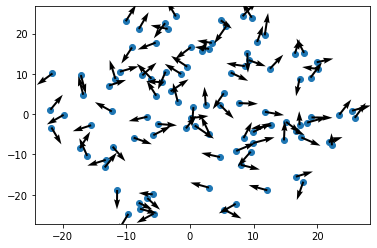

In [5]:
plt.scatter(data['x'][0][:,0],data['x'][0][:,1])
plt.quiver(data['x'][0][:,0],data['x'][0][:,1],data['x'][0][:,2],data['x'][0][:,3])

In [6]:
import numpy as np

def extend_simulation(data, steps=100, noise_std=10):
    new_data = np.zeros((steps+1, data.shape[1], data.shape[2]))
    new_data[0] = data
    
    for i in range(1, steps+1):
        noise = np.random.normal(0, noise_std, size=(data.shape[1], 2))
        new_data[i, :, :2] = new_data[i-1, :, :2] + new_data[i-1, :, 2:4] + noise
        new_data[i, :, 2:4] = new_data[i-1, :, 2:4]
        new_data[i, :, 4] = new_data[i-1, :, 4]
    
    return new_data

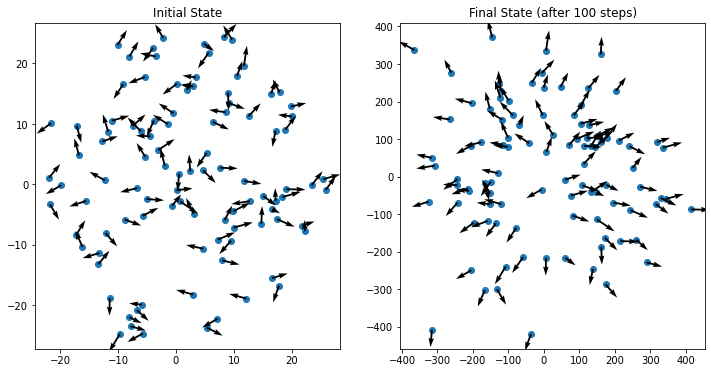

In [7]:

# Extend the simulation by 100 steps
extended_data = extend_simulation(data['x'], 100)

# Plot the initial state and final state
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].scatter(extended_data[0, :, 0], extended_data[0, :, 1])
ax[0].quiver(extended_data[0, :, 0], extended_data[0, :, 1], extended_data[0, :, 2], extended_data[0, :, 3])
ax[0].set_title("Initial State")

ax[1].scatter(extended_data[-1, :, 0], extended_data[-1, :, 1])
ax[1].quiver(extended_data[-1, :, 0], extended_data[-1, :, 1], extended_data[-1, :, 2], extended_data[-1, :, 3])
ax[1].set_title("Final State (after 100 steps)")

plt.show()

In [8]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

/home/nstillman/.local/lib/python3.8/site-packages/matplotlib/quiver.py:635: RuntimeWarning: Mean of empty slice.
  amean = a.mean()
/home/nstillman/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


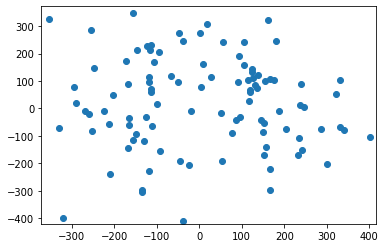

In [9]:

# Set up the figure and axis for the animation
fig, ax = plt.subplots()
sc = ax.scatter([], [])
qu = ax.quiver([], [], [], [])

# Initialization function for the animation
def init():
    ax.set_xlim(np.min(extended_data[:, :, 0]) - 1, np.max(extended_data[:, :, 0]) + 1)
    ax.set_ylim(np.min(extended_data[:, :, 1]) - 1, np.max(extended_data[:, :, 1]) + 1)
    
    sc.set_offsets(extended_data[0, :, :2])    
    return sc, qu,

# Update function for the animation
def update(frame):
    sc.set_offsets(extended_data[frame, :, :2])
    return sc, qu,

# Create the animation
ani = FuncAnimation(fig, update, frames=range(98), init_func=init, blit=True)

# Display the animation as a GIF in the Jupyter Notebook
HTML(ani.to_jshtml())


In [10]:


class Parameters(object):
    def __init__(self, p):
        for key, values in p.items():
            setattr(self, key, values)

class SyntheticData:
    def checkTypes(readtypes,data):
        #check which particles to load 
        if len(readtypes) > 0:
            usetypes = np.isin(data[:,-1],readtypes)
        else:
            usetypes = [True]*len(data)
        return usetypes

    # Data object for summary statistics
    def __init__(self,**kwargs):
        # check for debugging
        try:
            self.debug = kwargs['debug']
            if self.debug:
                print('kwargs: ', kwargs)
        except:
            self.debug = False
        # check for specific loadtimes
        try:    
            self.start = kwargs["loadtimes"][0]
            self.end = kwargs["loadtimes"][1]
            self.multiopt = True
        except:
            self.multiopt = False
        # check for specific types
        try:
            self.readtypes = kwargs["readtypes"]
        except:
            self.readtypes = []
            
        try:
            self.dt = kwargs["dt"]
        except:
            self.dt = 1
        # load parameters
        try:    
            self.param = Parameters(kwargs['params'])
        except Exception as e:
            print('Error! Parameters must be a dictionary' + e)
            return 1
        # load multiple simulation snapshots
        self.Nsnap = self.end - self.start + 1
        #get maximum number of particles
        self.N = sum(SimData.checkTypes(self.readtypes, kwargs['data'][0]))
        self.Nvals = []
        self.Nvariable =  False
        for t in range(self.start,self.end):
            self.Nvals.append(sum(SimData.checkTypes(self.readtypes, kwargs['data'][t])))
            if self.Nvals[t] > self.N:
                self.N = self.Nvals[t] 
                self.Nvariable = True
        if kwargs['trackAll'] and self.Nvariable == False:
            self.Ntracers = self.Nvals[0]
        else:
            print('Error! Currently assuming tracking all cells')
        self.data = kwargs['data']
        print(self.data.shape[-1])
        self.flag = np.zeros((self.Nsnap,self.N))
        if self.data.shape[-1] == 5:
            self.Z = self.data[:,:,4]
        else:
            np.zeros((self.Nsnap,self.N))
            
        self.rval = self.data[:,:,:2]
        self.vval = self.data[:,:,2:4]
        self.theta = np.zeros((self.Nsnap,self.N))
        self.nval = np.zeros((self.Nsnap,self.N,2))
        self.radius = np.ones((self.Nsnap,self.N))
        self.ptype = np.ones((self.Nsnap,self.N))
        self.sigma = 0.
        
        return None

    def gettypes(self, readtypes, frames):
        return np.isin(self.ptype[frames],readtypes)

    def truncateto(self,start, endtime):
        self.Nsnap = endtime - start
        self.flag =  self.flag[start:endtime]
        self.rval = self.rval[start:endtime]
        self.vval = self.vval[start:endtime]
        self.theta = self.theta[start:endtime]
        self.nval = self.nval[start:endtime]
        self.radius = self.radius[start:endtime]
        self.ptype = self.ptype[start:endtime]
        self.Nvals = self.Nvals[start:endtime]
        self.Ntracers = self.Ntracers[start:endtime]


In [15]:
import json 

configfile = "include/config/simconfig_open.json"


with open(configfile) as jsonFile:
    parameters = json.load(jsonFile)

data = SyntheticData(loadtimes = [0,100], types = [0,1], debug = False, data = extended_data, params = parameters, trackAll=True, dt = 1)


5


In [16]:
import allium.summstats as ss

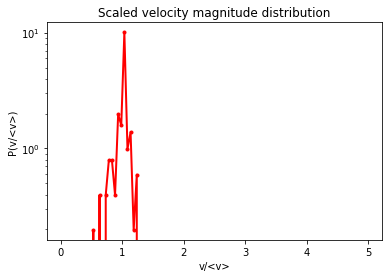

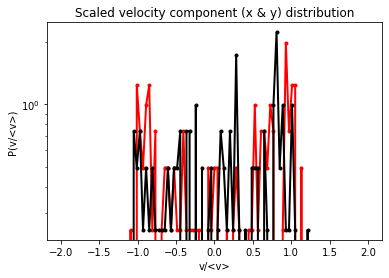

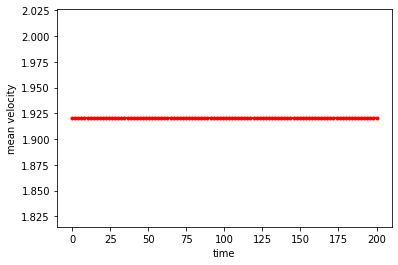

In [17]:
velbins=np.linspace(0,5,100)
velbins2=np.linspace(-2,2,100)
vav, vdist,vdist2 = ss.getVelDist(data, velbins,velbins2, usetype=[0,1],verbose=True)

vdist = vdist[1:]
vdist2 = vdist2[vdist2 != max(vdist2)]


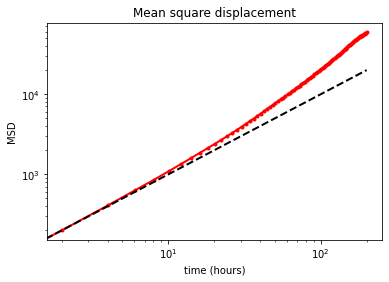

In [18]:
tval, msd, d = ss.getMSD(data, usetype=[1],verbose=True)
